# The NYPD has just arrested someone. You are told the following about the person arrested: crime commited, gender, age, and location of crime. Can you predict the race of the person with accuracy and precision?

# In order to answer if it is possible to predict the race, create a classifier.
First load the data and explore.

In [223]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [224]:
#Load in the data
data = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv')
#Look at five rows
data.head(5)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,206892169,12/31/2019,907.0,"IMPAIRED DRIVING,DRUG",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U4,M,M,33,0,25-44,M,WHITE,1000916,245710,40.841085,-73.939769
1,206888084,12/31/2019,739.0,"FRAUD,UNCLASSIFIED-FELONY",112.0,THEFT-FRAUD,PL 1908301,F,Q,101,0,25-44,M,BLACK HISPANIC,1055868,156522,40.596012,-73.742116
2,206890433,12/31/2019,122.0,"HOMICIDE, NEGLIGENT, VEHICLE,",102.0,HOMICIDE-NEGLIGENT-VEHICLE,PL 1251201,F,M,23,0,18-24,M,BLACK,997462,227024,40.789803,-73.952289
3,206890441,12/31/2019,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,S,120,0,18-24,M,BLACK,962822,174282,40.645023,-74.077217
4,206890973,12/31/2019,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,25,97,25-44,M,BLACK,1004138,226326,40.787875,-73.928182


In [225]:
#Look at the columns and rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214617 entries, 0 to 214616
Data columns (total 18 columns):
ARREST_KEY           214617 non-null int64
ARREST_DATE          214617 non-null object
PD_CD                214576 non-null float64
PD_DESC              214458 non-null object
KY_CD                214458 non-null float64
OFNS_DESC            214458 non-null object
LAW_CODE             214617 non-null object
LAW_CAT_CD           213248 non-null object
ARREST_BORO          214617 non-null object
ARREST_PRECINCT      214617 non-null int64
JURISDICTION_CODE    214617 non-null int64
AGE_GROUP            214617 non-null object
PERP_SEX             214617 non-null object
PERP_RACE            214617 non-null object
X_COORD_CD           214617 non-null int64
Y_COORD_CD           214617 non-null int64
Latitude             214617 non-null float64
Longitude            214617 non-null float64
dtypes: float64(4), int64(5), object(9)
memory usage: 29.5+ MB


In [226]:
#The Data Dictionary for the Columns obtained from the NYPD Website
data_dictionary = """
ARREST_KEY: Randomly generated persistent ID for each arrest

ARREST_DATE: Exact date of arrest for the reported event

PD_CD: Three digit internal classification code (more granular than
Key Code)

PD_DESC: Description of internal classification corresponding with PD
code (more granular than Offense Description)

KY_CD: Three digit internal classification code (more general
category than PD code)

OFNS_DESC: Description of internal classification corresponding with KY
code (more general category than PD description)

LAW_CODE: Law code charges corresponding to the NYS Penal Law,
VTL and other various local laws

LAW_CAT_CD: Level of offense: felony, misdemeanor, violation

ARREST_BORO: Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn),
M(Manhattan), Q(Queens)

ARREST_PRECINCT: Precinct where the arrest occurred

JURISDICTION_CODE: Jurisdiction responsible for arrest. Jurisdiction codes
0(Patrol), 1(Transit) and 2(Housing) represent NYPD whilst
codes 3 and more represent non NYPD jurisdictions

AGE_GROUP: Perpetrator’s age within a category

PERP_SEX: Perpetrator’s sex description

PERP_RACE: Perpetrator’s race description

X_COORD_CD: Midblock X-coordinate for New York State Plane
Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Y_COORD_CD: Midblock Y-coordinate for New York State Plane
Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Latitude: Latitude coordinate for Global Coordinate System, WGS
1984, decimal degrees (EPSG 4326)

Longitude: Longitude coordinate for Global Coordinate System, WGS
1984, decimal degrees (EPSG 4326)

"""

In [212]:
#change borough columns to make it clear
borough= {'K': 'Brooklyn', 'M': 'Manhattan','B':'Bronx','Q':"Queens", 'S':'Staten Island'}
#change the crime labels to make it clear
crimes = {'M': 'Misdemeanor', 'F':'Felony', 'V':'Violation' ,'I':'Infraction'}
#change the gender labels
gender = {'M': 'Male', 'F':'Female'}
#Replace borough label
data['ARREST_BORO'] = data['ARREST_BORO'].replace(borough)
#Replace Crime label
data['LAW_CAT_CD'] = data['LAW_CAT_CD'].replace(crimes)
#Replace gender label
data['PERP_SEX'] =  data['PERP_SEX'].replace(gender)


In [227]:
#Look at the unique values for each column with less than 20 unique values
for column in data.columns:
    if len(data[column].unique()) <20:
        print(column,':',data[column].unique())

LAW_CAT_CD : ['M' 'F' 'V' 'I' nan]
ARREST_BORO : ['M' 'Q' 'S' 'K' 'B']
AGE_GROUP : ['25-44' '18-24' '45-64' '<18' '65+']
PERP_SEX : ['M' 'F']
PERP_RACE : ['WHITE' 'BLACK HISPANIC' 'BLACK' 'WHITE HISPANIC' 'UNKNOWN'
 'ASIAN / PACIFIC ISLANDER' 'AMERICAN INDIAN/ALASKAN NATIVE']


The above categorical values are found in the data. The LAW_CAT_CD is type of crime indicator (dictionary above) that lists felony, misdemeanor, violation, etc. The others are Borough (ARREST_BORO), age group (AGE_GROUP), gender (PERP_SEX), and race (PERP_RACE).

Let me look at columns that have more than 20 unique values next.
Because the dataframe is 214617 rows long (as seen in the output from data.info()), I am going to keep any column with unique features that are under 1000 in number. Even though 1000 is a big number, it is much smaller than ~200,000. To be exact, it is half a percent.

In [221]:
#Look at the unique values for columns containing greater than 20 values
#We don't want TOO MUCH variability because easier to cause overfitting
for column in data.columns:
    print(column,'unique values:',len(data[column].unique()))

ARREST_KEY unique values: 214617
ARREST_DATE unique values: 365
PD_CD unique values: 274
PD_DESC unique values: 260
KY_CD unique values: 70
OFNS_DESC unique values: 66
LAW_CODE unique values: 1144
LAW_CAT_CD unique values: 5
ARREST_BORO unique values: 5
ARREST_PRECINCT unique values: 77
JURISDICTION_CODE unique values: 25
AGE_GROUP unique values: 5
PERP_SEX unique values: 2
PERP_RACE unique values: 7
X_COORD_CD unique values: 30379
Y_COORD_CD unique values: 32192
Latitude unique values: 38443
Longitude unique values: 38452


In [229]:
#Based on the above unique counts, I will select the following columns to drop 
#because they are not useful features to train a classifier.
drop_following = """
Columns to drop:

ARREST_KEY: this is a unique identifier used internally by the NYPD. It serves no purpose here.
ARREST_DATE: WE will drop this and bin it into to Month
X_COORD_CD: Not using coordinates in logistic regression
Y_COORD_CD: Not using coordinates in logistic regression
Latitude: Not using coordinates
Longitude: Not using coordinates

"""

In [230]:
#Drop the columns that wont provide informational value
data.drop(['ARREST_KEY', 'X_COORD_CD','Y_COORD_CD', 'Latitude','Longitude'], axis=1, inplace=True)

In [231]:
#How many empty values are there in each column?
data.isnull().sum()

ARREST_DATE             0
PD_CD                  41
PD_DESC               159
KY_CD                 159
OFNS_DESC             159
LAW_CODE                0
LAW_CAT_CD           1369
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
dtype: int64

In [232]:
#Because there are not that many nulls, won't worry about them, just going to drop them
data.dropna(inplace=True)

In [239]:
data['ARREST_DATE'] = pd.to_datetime(data['ARREST_DATE'], format = "%m/%d/%Y")

In [240]:
#Create a catagoric column for month
data['ARREST_DATE'].month


AttributeError: 'Series' object has no attribute 'month'

Text(0, 0.5, 'Number of Arrested')

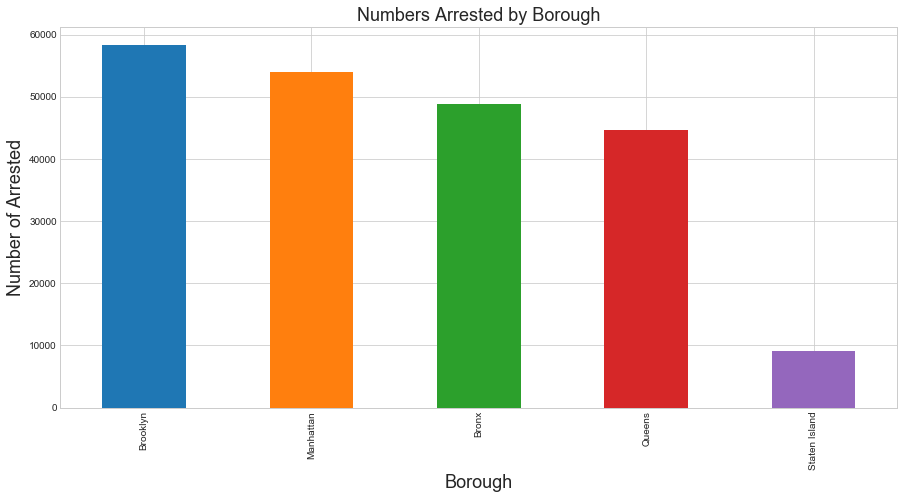

In [196]:
#Number of arrests by Borough
arrest_by_boro = data.groupby('ARREST_BORO').ARREST_BORO.count()
arrest_by_boro = pd.DataFrame(arrest_by_boro.sort_values(ascending = False))
#Plot race of arrested
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(15, 7))
ax = plt.axes()
ax = data.ARREST_BORO.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested by Borough',fontsize=18)
ax.set_xlabel("Borough",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

In [111]:
#Male vs Female
counts = data.PERP_SEX.value_counts()
percent = data.PERP_SEX.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent':percent})

,Counts,Percent
M,173964,81.64%
F,39125,18.36%


In [110]:
#Race of Arrested
counts = data.PERP_RACE.value_counts()
percent = data.PERP_RACE.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent': percent})

,Counts,Percent
BLACK,101979,47.86%
WHITE HISPANIC,53265,25.0%
WHITE,25284,11.87%
BLACK HISPANIC,18550,8.71%
ASIAN / PACIFIC ISLANDER,12013,5.64%
UNKNOWN,1401,0.66%
AMERICAN INDIAN/ALASKAN NATIVE,597,0.28%


Text(0, 0.5, 'Number of Arrested')

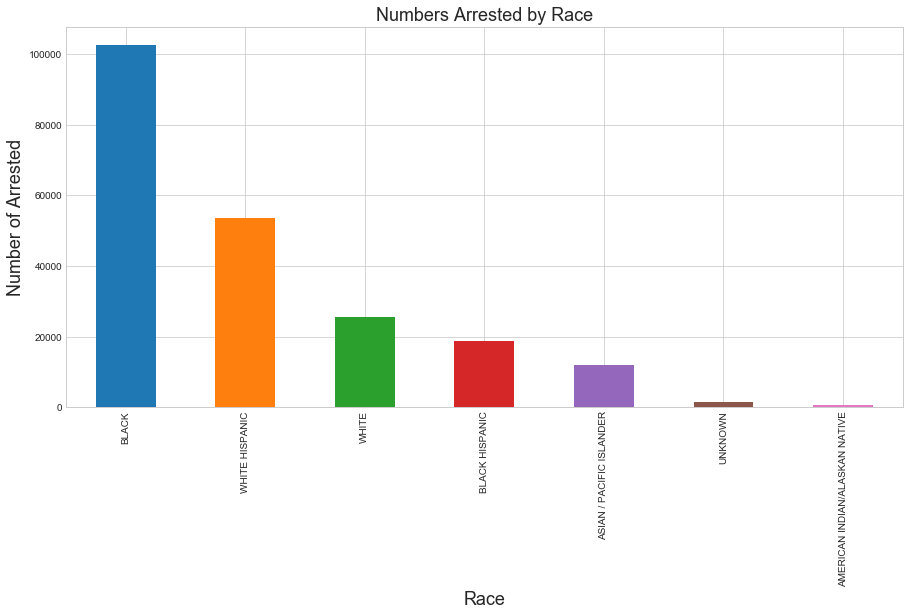

In [189]:
#Plot race of arrested
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(15, 7))
ax = plt.axes()
ax = data.PERP_RACE.value_counts(sort =True).plot(kind='bar')
ax.set_title('Numbers Arrested by Race',fontsize=18)
ax.set_xlabel("Race",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

Black persons take up a majority of those arrested

In [112]:
#Age Group of Arrested
counts = data.AGE_GROUP.value_counts()
percent = data.AGE_GROUP.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent': percent})

,Counts,Percent
25-44,113292,53.17%
18-24,43275,20.31%
45-64,43249,20.3%
<18,10260,4.81%
65+,3013,1.41%


In [120]:
#Races of the Arrested by Age Group
counts = data.groupby('AGE_GROUP').PERP_RACE.value_counts(sort=True)
pd.DataFrame({'Counts': counts})

Counts
AGE_GROUP PERP_RACE                             
18-24     BLACK                            21972
          WHITE HISPANIC                   10700
          BLACK HISPANIC                    4548
          WHITE                             3230
          ASIAN / PACIFIC ISLANDER          2397
          UNKNOWN                            284
          AMERICAN INDIAN/ALASKAN NATIVE     144
25-44     BLACK                            51943
          WHITE HISPANIC                   29767
          WHITE                            14187
          BLACK HISPANIC                    9982
          ASIAN / PACIFIC ISLANDER          6292
          UNKNOWN                            809
          AMERICAN INDIAN/ALASKAN NATIVE     312
45-64     BLACK                            20685
          WHITE HISPANIC                   10022
          WHITE                             6651
          BLACK HISPANIC                    2853
          ASIAN / PACIFIC ISLANDER          2657
          UNKNOWN                            263
          AMERICAN INDIAN/ALASKAN NATIVE     118
65+       BLACK                             1138
          WHITE                              781
          WHITE HISPANIC                     620
          ASIAN / PACIFIC ISLANDER           268
          BLACK HISPANIC                     189
          UNKNOWN                             11
          AMERICAN INDIAN/ALASKAN NATIVE       6
<18       BLACK                             6241
          WHITE HISPANIC                    2156
          BLACK HISPANIC                     978
          WHITE                              435
          ASIAN / PACIFIC ISLANDER           399
          UNKNOWN                             34
          AMERICAN INDIAN/ALASKAN NATIVE      17

Text(0, 0.5, 'Number of Arrested')

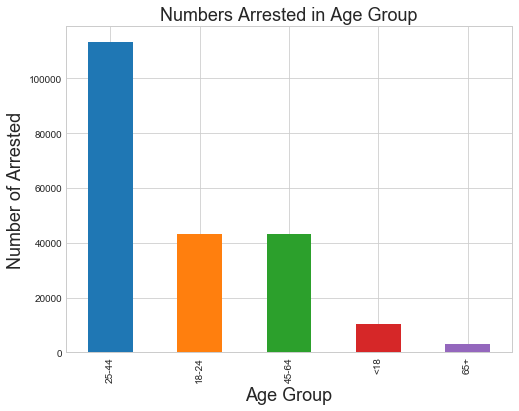

In [155]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
ax = data.AGE_GROUP.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Age Group',fontsize=18)
ax.set_xlabel("Age Group",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

Most of those arrested are between 25 to 44. 

Text(0, 0.5, 'Number of Arrested')

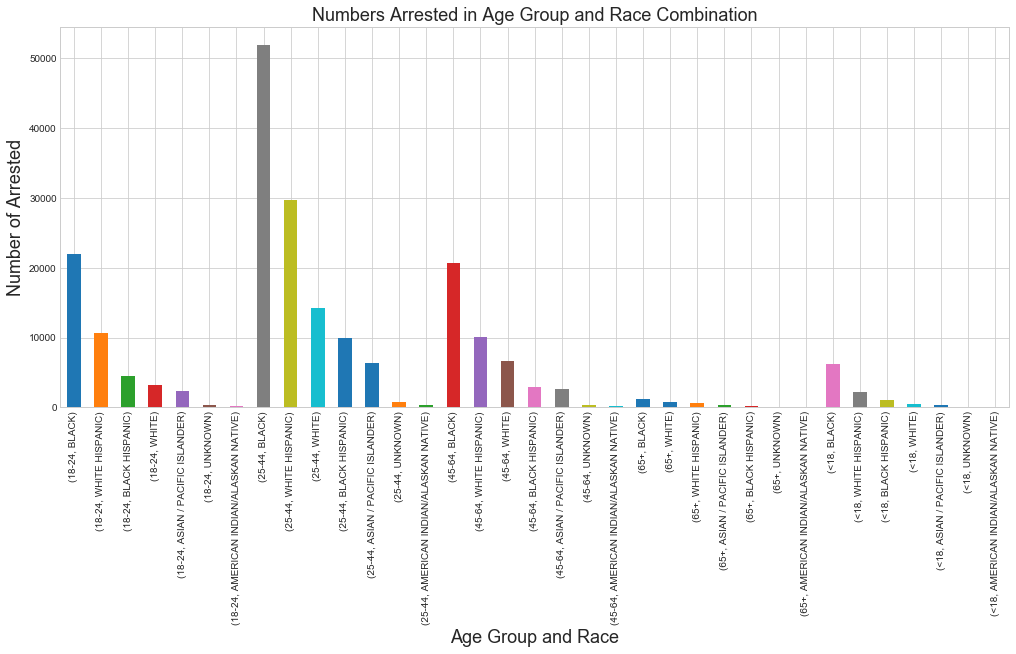

In [156]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(17, 7))
ax = plt.axes()
ax = data.groupby('AGE_GROUP').PERP_RACE.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Age Group and Race Combination',fontsize=18)
ax.set_xlabel("Age Group and Race",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

Text(0, 0.5, 'Number of Arrested')

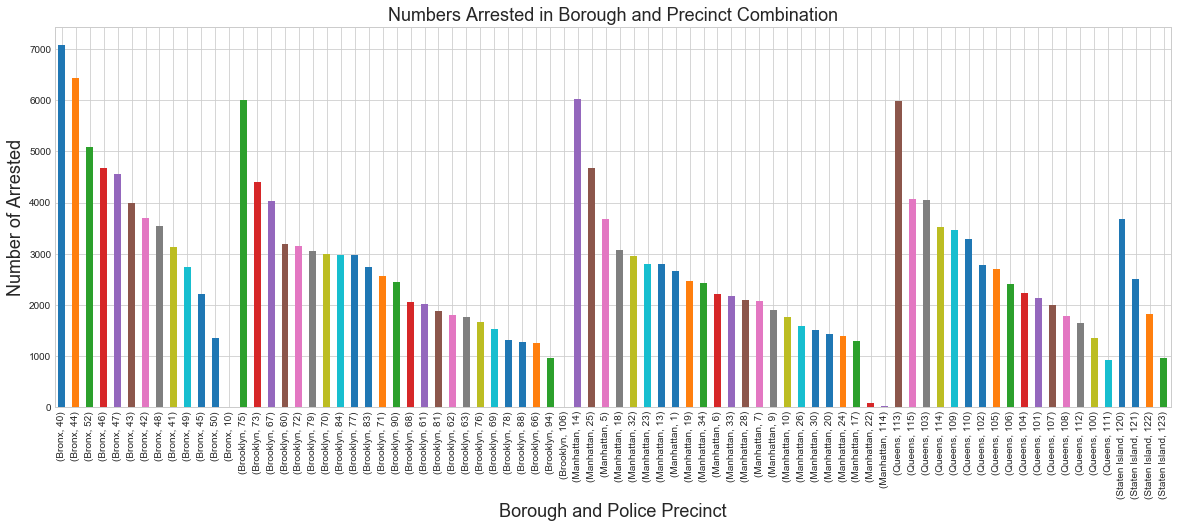

In [163]:
#Arrests by Boro Precinct
fig = plt.figure(num=None, figsize=(20, 7))
ax = plt.axes()
ax = data.groupby('ARREST_BORO').ARREST_PRECINCT.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Borough and Precinct Combination',fontsize=18)
ax.set_xlabel("Borough and Police Precinct",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

Some precincts in every borough have a high number of arrests.

In [200]:
data.groupby('LAW_CAT_CD')['ARREST_BORO'].value_counts().sort_values(ascending = False)

LAW_CAT_CD  ARREST_BORO  
M           Manhattan        33072
            Bronx            30709
            Brooklyn         30620
            Queens           26792
F           Brooklyn         26110
            Manhattan        19054
            Bronx            17579
            Queens           17092
M           Staten Island     5416
F           Staten Island     3549
V           Brooklyn          1152
            Manhattan         1065
            Queens             359
            Bronx              223
I           Brooklyn           220
            Queens             112
            Manhattan           62
            Bronx               28
V           Staten Island       23
I           Staten Island       11
Name: ARREST_BORO, dtype: int64